# divide observations into watermasses based on location

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [3]:
# salish sea cuttoff
x = np.linspace(-130,-122,10)
m = -0.83
b = 48.4-(-124.6)*m

ind = np.where(obs['longitude (degrees_east)'] > (obs['latitude (degrees_north)']-b)/m) 
obs = obs.drop(ind[0])
obs.reset_index(drop=True, inplace=True)

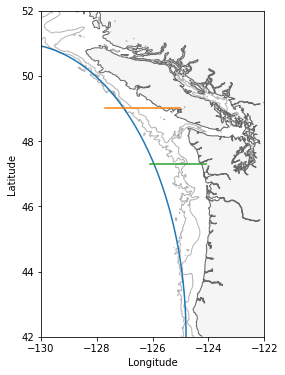

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)
# ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[2000], colors='r')

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# offshore cuttoff 
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(9**2))*(6**2))-130.8
ax.plot(x,y)

#north cuttoff
ax.plot([-127.7,-125],[49,49])

# south cuttoff
ax.plot([-126.1,-124.1],[47.3,47.3])
# south deep s>=33.9
# south shelf s>=32 <33.9
# south fresh s<32

In [7]:
# code for separating observations into groups based on location and depth
def region(lat,lon,salinity,d):
    if  lon > np.sqrt((1-(((lat-42)**2)/(9**2)))*(6**2))-130.8:
        return 1 #offshore
    elif lat > 49:
        return 2 #north
    elif lat < 47.3:
        if salinity >= 33.9:
            return 3 #south
        elif salinity < 32:
            return 4
        else:
            return 5
    else:
        return 6  #domain

regions = ['Offshore', 'North', 'South Deep', 'South Fresh', 'South Shelf']

In [9]:
obs['region'] = [region(obs['latitude (degrees_north)'][i],obs['longitude (degrees_east)'][i],obs['salinity (g kg-1)'][i],obs['depth (m)'][i]) for i in range(len(obs))]

In [ ]:
# south only
fig, ax = plt.subplots(2,2, figsize=(10,10))
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
salt, temp, trans, depth = get_data_south(mydata, sum_start[2], sum_end[-1])

# first summer, coloured by transport
bins = [np.linspace(29,34.6,100),np.linspace(6,14.01,100)]

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0,0].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=1000))
ax[0,0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
# cb = fig.colorbar(im, ax=ax[0])
# cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

# and coloured by depth
cmap = cm.cm.deep
idx = depth.argsort()
salt, temp, depth = salt[idx][::-1], temp[idx][::-1], depth[idx][::-1]*-1
sc=ax[1,0].scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
ax[1,0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1,0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)

# second for winter
time = win_end[-1] - win_start[0] + 1 + sum_end[1] - sum_start[0] + 1

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW16, tempW16, transW16, depthW16 = get_data_south(mydata, win_start[0], win_end[-1])

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltS, tempS, transS, depthS = get_data_south(mydata, sum_start[0], sum_end[1])

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
saltW17, tempW17, transW17, depthW17  = get_data_south(mydata, win_start[0], win_end[-1])

salt = np.append((np.append(saltW16, saltS)), saltW17)
temp = np.append((np.append(tempW16, tempS)), tempW17)
trans = np.append((np.append(transW16, transS)), transW17)
depth = np.append((np.append(depthW16, depthS)), depthW17)

H, xedges, yedges=np.histogram2d(salt,temp,weights=trans,bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0,1].pcolormesh(X, Y, H_final, cmap=cmap, norm=colors.LogNorm(vmin=10, vmax=1000))
cb = fig.colorbar(im, ax=ax[0,1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

# and depth in winter
cmap = cm.cm.deep
idx = depth.argsort()
salt, temp, depth = salt[idx][::-1], temp[idx][::-1], depth[idx][::-1]*-1
sc=ax[1,1].scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
cb = fig.colorbar(sc, ax=ax[1,1])
cb.set_label('Depth [m]', labelpad=10, fontsize=14)
ax[1,1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)

letter = ['a)', 'b)','c)','d)']
ii=[0,0,1,1]
jj=[0,1,0,1]
for k in range(4):
    CS=ax[ii[k],jj[k]].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[ii[k],jj[k]].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax[ii[k],jj[k]].set_yticks(np.arange(6,17,1))
    ax[ii[k],jj[k]].set_yticklabels(np.arange(6,17,1),fontsize=12)
    ax[ii[k],jj[k]].set_xticks(np.arange(26,35,1))
    ax[ii[k],jj[k]].set_xticklabels(np.arange(26,35,1),fontsize=12)
    ax[ii[k],jj[k]].set_ylim([6, 14])
    ax[ii[k],jj[k]].set_xlim([29, 34.5])

    # division between water masses
    ax[ii[k],jj[k]].plot([33.9,33.9],[6,14],'r--', alpha=0.7, label='Deep division')
    ax[ii[k],jj[k]].plot([34.1,34.1],[6,14],'k', alpha=0.3)
    ax[ii[k],jj[k]].plot([33.7,33.7],[6,14],'k', alpha=0.3)

    # columbia delineation
    ax[ii[k],jj[k]].plot([32,32],[6,14],'g--',alpha=0.7,label='Columbia division')
    ax[ii[k],jj[k]].plot([32.2,32.2],[6,14],'k', alpha=0.3)
    ax[ii[k],jj[k]].plot([31.8,31.8],[6,14],'k', alpha=0.3)

    #text
    plt.text(.05, .95, letter[k], ha='left', va='top', transform=ax[ii[k],jj[k]].transAxes, fontsize=14)

ax[1,0].legend(loc='lower left', fontsize=12)
ax[0,0].set_title('Summer', fontsize=12)
ax[0,1].set_title('Winters', fontsize=12)